## Data wrangling and visualization on WeRateDogs tweets information

### Introduction

WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though almost always greater than 10 e.g., 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." 

WeRateDogs has over 4 million followers and has received international media coverage.

Since real-world dataset rarely comes clean, I will be using Python and its libraries to gather data from variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called **data wrangling**!

### Data Gathering Section

Before importing and gathering additional tweet data, it will be reasonable to import all necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
import re
import requests
import tweepy
from PIL import Image
from io import BytesIO

plt.style.use('fivethirtyeight')
%matplotlib inline

**Loading twitter archive dataset**

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

**Getting image prediction of different dogs at [Udacity server](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)**

In [3]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [4]:
# Saving the image prediction into a tsv file
with open('image_predictions.tsv', 'wb') as file: 
    file.write(response.content)

**Loading image_predictions.tsv file into a dataframe**

In [5]:
image_pred = pd.read_csv('image_predictions.tsv', sep='\t')

**Getting more data information about different tweetids in twitter archive dataframe**

In [6]:
from getpass import getpass # Package to get consumer key and secret as a password

In [7]:
consumer_key = getpass("Consumer key:") # Getting the consumer key from stdin
consumer_secret = getpass("Consumer secret:") # Getting the consumer secret from stdin

auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 

access_token = getpass("Access Token:")
access_secret = getpass('Access secret:')

auth.set_access_token(access_token, access_secret) # Setting the access tokens

api = tweepy.API(auth, wait_on_rate_limit=True) # Initializing the API

with open('tweet_json.txt', 'w') as file:
    for tweetid in twitter_archive['tweet_id'].values:
        try:
            tweet = api.get_status(tweetid, tweet_mode='extended') # Getting different tweets
            json.dump(tweet._json, file) # Saving the tweet as json file
            file.write('\n') # Adding newline character after saving 
        except:
            print(f'{tweetid} not found!') # This will get prompt when tweet id is not found

**Loading the tweets retrieved from twitter into a dataframe**

In [8]:
tweets_use = (pd.read_json('tweet_json.txt', lines=True)
                .loc[:, ['id', 'retweet_count', 'favorite_count']])

### Accessing Data

#### Asessing Twitter archive file

In [9]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

> Observation

- Misrepresentation of data type e.g., `tweet_id` column is integer instead of string.
- There are only 78 values in `in_reply_to_status_id` and `in_reply_to_user_id` columns.
- Timestamp column is a string, instead of datetime object.
- There are 181 non-null values in `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` columns.
- Out of 2356 rows, `expanded_urls` columns has 2297 non-null values.
- Misrepresentation of NA value in different columns.
- Dog stages has 4 columns i.e., `doggo`, `floofer`, `pupper`, `puppo`

**Number of NA in the dataset**

In [11]:
twitter_archive.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

##### Ratings column

**Descriptive analysis on numerical columns**

In [12]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


> Observation

Both minimum and maximum ratings numerator and denominator are wrong because ratings numerator or denominator are not suppose to be this low or high!

In [13]:
wrong_denom = (twitter_archive.query('rating_denominator != 10')[
    ['text', 'rating_numerator', 'rating_denominator']]
    .head())
wrong_denom

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,"RT @dog_rates: After so many requests, this is...",9,11


In [14]:
wrong_denom.loc[313, 'text']

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

> Observation

As this can be seen, some ratings numerator and denominator are chosen wrongly from the `text` column.

In [15]:
# Checking for wrong ratings representation
wrong_repr = (twitter_archive[twitter_archive['text']
                .str.contains(r'\d+.\d+/\d+')]
                [['text', 'rating_numerator', 'rating_denominator']])
wrong_repr.head()

,text,rating_numerator,rating_denominator
45,This is Bella. She hopes her smile made you sm...,5,10
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,@s8n You tried very hard to portray this good ...,666,10
290,@markhoppus 182/10,182,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0


In [16]:
wrong_repr.loc[45, 'text']

'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'

> Observation

- As can be seen, some numerators and denominators were wrongly represented. Instead 13.5/10, 5/10 was used in the dataframe.
- Text column have an unknow url at the end of each tweet.

##### Tweet id column

**Checking for duplicate values on `tweet_id`**

In [17]:
twitter_archive.tweet_id.duplicated().any()

False

> Observation

All tweets are unique, there is no duplicate

##### Name column

In [18]:
twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [19]:
twitter_archive['name'].value_counts().sort_index()

Abby            2
Ace             1
Acro            1
Adele           1
Aiden           1
               ..
such            1
the             8
this            1
unacceptable    1
very            5
Name: name, Length: 957, dtype: int64

> Observation

There are some unknown dog names i.e., a, "None", "such", "the", "this", "unacceptable", "very" etc., But all unknown names have the same pattern except for None (lower case).

##### Dog stages

In [20]:
# Checking for the unique values
for column in twitter_archive.loc[:, "doggo":].columns:
    print(column, "column values:", twitter_archive[column].unique())

doggo column values: ['None' 'doggo']
floofer column values: ['None' 'floofer']
pupper column values: ['None' 'pupper']
puppo column values: ['None' 'puppo']


> Observation
None is not saved as N/A

#### Assessing additional tweet information

In [21]:
tweets_use.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [22]:
tweets_use.id.duplicated().any()

False

> Observation

All tweets are unique, there is no duplicate

In [23]:
# brief information of tweets
tweets_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


> Observation

- id is a string and not integer

**Descriptive analysis on numerical columns**

In [24]:
tweets_use.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


#### Assessing image prediction

Description of image prediction columns:

- `tweet_id`: the unique identifier for each tweet
- `jpg_url`: dog's image URL
- `img_num`: the image number that corresponded to the most confident prediction
- `p1`: algorithm's #1 prediction for the image in the tweet
- `p1_conf`: how confident the algorithm is in its #1 prediction
- `p1_dog`: whether or not the #1 prediction is a breed of dog
- `p2`: algorithm's #2 prediction for the image in the tweet
- `p2_conf`: how confident the algorithm is in its #2 prediction
- `p2_dog`: whether or not the #2 prediction is a breed of dog
- `p3`: algorithm's #3 prediction for the image in the tweet
- `p3_conf`: how confident the algorithm is in its #3 prediction
- `p3_dog`: whether or not the #3 prediction is a breed of dog

In [25]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [26]:
# brief info of image prediction dataframe
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> Observation
- Data quality issue i.e., misrepresentation of `tweet_id`.
- Also, inconsistent dog breed name i.e., uppercase and lowercase
- Names separated with "_" instead of " ".

**Descriptive analysis on numerical columns**

In [27]:
image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### Quality
**Twitter archive table**
- Erroneous data type e.g., tweet id is string instead of int and timestamp is datetime object instead of string.
- Misrepresentation of NA values in different columns such as Doggo, Floofer, Pupper, Puppo etc.
- Redundant urls in source column (Only text in \<a>text\</a> is needed)
- Unknown url at end tweet text
- Invalid ratings representation i.e., some ratings are wrongly represented e.g., 5/10 instead of 13.5/10.
- Invalid huge ratings numerator and denominator.
- Retweeted tweets (181) and replies (78) not needed.
- Invalid dogs name e.g., "a", "such", "quite", "None", etc.
- Retweet columns and replies not needed.
- Tweet without dog image found

**Tweets table**
- Erroneous datatype (id)

**Image prediction table**
- Erroneous datatype (tweet_id)
- Inconsistence dog breeds i.e., value separated with "_" instead of " " and also mixture of upper and lower case.

#### Tidiness
- There are 3 dataframe

**Twitter archive table**
- Dog stages in multiple columns (Instead of only one column).
- Two variables in Timestamp column (time and date).

**Image prediction table**
- Only best image prediction is needed.

### Clean

In [28]:
twitter_archive_clean = twitter_archive.copy()
tweets_clean = tweets_use.copy()
image_pred_clean = image_pred.copy()

##### Data Quality 1
`Twitter archive`: - Erroneous data type

##### Define

Use `pandas.to_datetime()` function to convert `timestamp` column to datetime object and change the data type of `id` column to str. Make sure to sort the dataframe ascending base on timestamp

##### Code

In [29]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

twitter_archive_clean.sort_values('timestamp', inplace=True)

In [30]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)

##### Test

In [31]:
twitter_archive_clean['timestamp'].head()

2355   2015-11-15 22:32:08+00:00
2354   2015-11-15 23:05:30+00:00
2353   2015-11-15 23:21:54+00:00
2352   2015-11-16 00:04:52+00:00
2351   2015-11-16 00:24:50+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [32]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [33]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2355 to 0
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

##### Tidiness issue 1

Two values in timestamp column (date & time)

##### Define

Extract both time and date from the timestamp object and delete the timestamp column after extraction.

##### Code

In [34]:
twitter_archive_clean['date'] = pd.to_datetime(twitter_archive_clean['timestamp'].dt.date)
twitter_archive_clean['time'] = twitter_archive_clean['timestamp'].dt.time

# Removing timestamp from the dataframe
twitter_archive_clean.drop(columns=['timestamp'], inplace=True)

##### Test

In [35]:
twitter_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
2355,666020888022790149,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,2015-11-15,22:32:08
2354,666029285002620928,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,2015-11-15,23:05:30


In [36]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2355 to 0
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   source                      2356 non-null   object        
 4   text                        2356 non-null   object        
 5   retweeted_status_id         181 non-null    float64       
 6   retweeted_status_user_id    181 non-null    float64       
 7   retweeted_status_timestamp  181 non-null    object        
 8   expanded_urls               2297 non-null   object        
 9   rating_numerator            2356 non-null   int64         
 10  rating_denominator          2356 non-null   int64         
 11  name                        2356 non-null   object      

##### Data Quality 2

`Twitter archive`: **Misrepresentation of NA values**

##### Define

Use `dataframe.replace()` function to replace all the "None" strings in the dog_stages columns

##### Code

In [37]:
twitter_archive_clean.loc[:, "doggo":'puppo'] = twitter_archive_clean.loc[:, "doggo":'puppo'].replace({'None': np.nan})

##### Test

In [38]:
twitter_archive_clean.loc[:5, "doggo":'puppo']

,doggo,floofer,pupper,puppo
2355,NaN,NaN,NaN,NaN
2354,NaN,NaN,NaN,NaN
2353,NaN,NaN,NaN,NaN
2352,NaN,NaN,NaN,NaN
2351,NaN,NaN,NaN,NaN
...,...,...,...,...
9,doggo,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN


In [39]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2355 to 0
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   source                      2356 non-null   object        
 4   text                        2356 non-null   object        
 5   retweeted_status_id         181 non-null    float64       
 6   retweeted_status_user_id    181 non-null    float64       
 7   retweeted_status_timestamp  181 non-null    object        
 8   expanded_urls               2297 non-null   object        
 9   rating_numerator            2356 non-null   int64         
 10  rating_denominator          2356 non-null   int64         
 11  name                        2356 non-null   object      

##### Tidiness issue 2

Twitter archive: **Dog stages requires only one column**

##### Define

Use melt() method to get all values of dog stages in one column and remove all redundant dog stage columns i.e., 'doggo', 'floofer', 'pupper', 'puppo'

In [40]:
dog_stage = twitter_archive_clean.melt(id_vars= ['tweet_id'],
                value_vars=('doggo', 'floofer', 'pupper', 'puppo'),
                    var_name='dogs_col', value_name='dog_stage')

dog_stage = dog_stage[~dog_stage['dog_stage'].isna()].drop('dogs_col', axis=1)

twitter_archive_clean = pd.merge(twitter_archive_clean, dog_stage, on='tweet_id', how='left')

# dog_stage is no longer
del dog_stage 

In [41]:

twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')

twitter_archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

##### Test

In [42]:
# All columns in the dataframe
twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'source',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'date', 'time', 'dog_stage'],
      dtype='object')

In [43]:
twitter_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,date,time,dog_stage
0,666020888022790149,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,2015-11-15,22:32:08,NaN
1,666029285002620928,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,2015-11-15,23:05:30,NaN


In [44]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370 entries, 0 to 2369
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2370 non-null   object        
 1   in_reply_to_status_id       79 non-null     float64       
 2   in_reply_to_user_id         79 non-null     float64       
 3   source                      2370 non-null   object        
 4   text                        2370 non-null   object        
 5   retweeted_status_id         183 non-null    float64       
 6   retweeted_status_user_id    183 non-null    float64       
 7   retweeted_status_timestamp  183 non-null    object        
 8   expanded_urls               2311 non-null   object        
 9   rating_numerator            2370 non-null   int64         
 10  rating_denominator          2370 non-null   int64         
 11  name                        2370 non-null   object      

##### Data Quality 3

Redundant urls in a source column

##### Define

Use regular expression pattern to extract the text in between the \<a> tag

##### Code

In [45]:
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.extract(r'<a.*>(.*)</a>')

##### Test

In [46]:
twitter_archive_clean['source'].head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object

##### Data Quality 4

`Tweet archive`: **Unknow url at the end of tweet texts.**

##### Define

Remove the url at the end of each tweet text using `replace()` method in str

##### Code

In [47]:
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.replace(r'\s*http\S*', "", regex=True)

##### Test

In [48]:
twitter_archive_clean['text'].str.contains('http').sum()

0

##### Data Quality 5

`Twitter archive`: **Invalid dogs name**

##### Define

Remove all dogs name with lower case and replace all "None" with np.nan in the dataframe.

##### Code

In [49]:
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean.name.str.islower()]

twitter_archive_clean.replace({"None": np.nan}, inplace=True)

##### Test

In [50]:
twitter_archive_clean.name.value_counts()

Charlie    12
Cooper     11
Oliver     11
Lucy       11
Tucker     10
           ..
Covach      1
Geoff       1
Maxwell     1
Oddie       1
Tilly       1
Name: name, Length: 931, dtype: int64

#### Data Quality 6

`Twitter archive`: **Invalid ratings representation**

##### Define

Extract both ratings numerator and denominator from the text column and use `astype()` method to change their type from str to float.

##### Code

In [51]:
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean['text'].str.extract(r'(\d+(?:\.\d+)?)/(\d+)', expand=True)

In [52]:
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean[['rating_numerator', 'rating_denominator']].astype(float)

##### Test

In [53]:
twitter_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,date,time,dog_stage
0,666020888022790149,NaN,NaN,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8.0,10.0,NaN,2015-11-15,22:32:08,NaN
4,666049248165822465,NaN,NaN,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5.0,10.0,NaN,2015-11-16,00:24:50,NaN


In [54]:
twitter_archive_clean['rating_numerator'].value_counts()

12.00      547
11.00      449
10.00      438
13.00      345
9.00       144
8.00        95
14.00       50
7.00        49
5.00        35
6.00        30
3.00        18
4.00        14
1.00         8
2.00         7
15.00        2
9.75         2
420.00       2
0.00         2
182.00       1
960.00       1
84.00        1
666.00       1
17.00        1
24.00        1
11.27        1
165.00       1
1776.00      1
143.00       1
50.00        1
99.00        1
80.00        1
45.00        1
44.00        1
121.00       1
20.00        1
9.50         1
11.26        1
144.00       1
88.00        1
13.50        1
Name: rating_numerator, dtype: int64

In [55]:
twitter_archive_clean['rating_denominator'].value_counts()

10.0     2239
11.0        3
80.0        2
20.0        2
50.0        2
120.0       1
16.0        1
110.0       1
130.0       1
40.0        1
90.0        1
150.0       1
7.0         1
70.0        1
15.0        1
0.0         1
Name: rating_denominator, dtype: int64

In [56]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2259 entries, 0 to 2369
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2259 non-null   object        
 1   in_reply_to_status_id       79 non-null     float64       
 2   in_reply_to_user_id         79 non-null     float64       
 3   source                      2259 non-null   object        
 4   text                        2259 non-null   object        
 5   retweeted_status_id         177 non-null    float64       
 6   retweeted_status_user_id    177 non-null    float64       
 7   retweeted_status_timestamp  177 non-null    object        
 8   expanded_urls               2200 non-null   object        
 9   rating_numerator            2259 non-null   float64       
 10  rating_denominator          2259 non-null   float64       
 11  name                        1506 non-null   object      

#### Data Quality 7

`Twitter archive`: **Huge ratings numerator and denominator are invalid**

##### Define

Use pandas `query()` method to extract dataframe with ratings denominator of 10 and ratings numerator <= 14. Evaluate the rating_numerator column by dividing it by 10. Make sure to remove ratings denominator and ratings numerator from the dataframe since we have the final rating.

##### Code

In [57]:
# Some ratings denominator > 10 are invalid for this analysis. 
twitter_archive_clean = twitter_archive_clean.query('rating_denominator == 10 & rating_numerator <= 14')

# final ratings in percentage
twitter_archive_clean['final_ratings'] = twitter_archive_clean['rating_numerator']/10

In [58]:
twitter_archive_clean.drop(columns=['rating_numerator', 'rating_denominator'], inplace=True)

##### Test

In [59]:
twitter_archive_clean['final_ratings'].head()

0     0.8
4     0.5
11    0.9
12    1.0
13    0.6
Name: final_ratings, dtype: float64

In [60]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2231 entries, 0 to 2369
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2231 non-null   object        
 1   in_reply_to_status_id       69 non-null     float64       
 2   in_reply_to_user_id         69 non-null     float64       
 3   source                      2231 non-null   object        
 4   text                        2231 non-null   object        
 5   retweeted_status_id         175 non-null    float64       
 6   retweeted_status_user_id    175 non-null    float64       
 7   retweeted_status_timestamp  175 non-null    object        
 8   expanded_urls               2181 non-null   object        
 9   name                        1502 non-null   object        
 10  date                        2231 non-null   datetime64[ns]
 11  time                        2231 non-null   object      

#### Data Quality 8

`Twitter archive`: **Retweeted tweets and replies not needed.**

##### Define

Remove all retweeted tweets and replies

##### Code

In [61]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isna()]
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_user_id'].isna()]

##### Test

In [62]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2369
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1987 non-null   object        
 1   in_reply_to_status_id       0 non-null      float64       
 2   in_reply_to_user_id         0 non-null      float64       
 3   source                      1987 non-null   object        
 4   text                        1987 non-null   object        
 5   retweeted_status_id         0 non-null      float64       
 6   retweeted_status_user_id    0 non-null      float64       
 7   retweeted_status_timestamp  0 non-null      object        
 8   expanded_urls               1984 non-null   object        
 9   name                        1390 non-null   object        
 10  date                        1987 non-null   datetime64[ns]
 11  time                        1987 non-null   object      

#### Data Quality 9

`Twitter archive`: **Retweet columns and replies are no longer needed**

##### Define

Drop all retweet and replies columns using `drop()` method in pandas

##### Code

In [63]:
colto_drop = (i for i in twitter_archive_clean.columns if re.search(r'retweet.*|in_reply.*', i))

twitter_archive_clean.drop(columns=colto_drop, inplace=True)

##### Test

In [64]:
twitter_archive_clean.columns

Index(['tweet_id', 'source', 'text', 'expanded_urls', 'name', 'date', 'time',
       'dog_stage', 'final_ratings'],
      dtype='object')

In [65]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2369
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       1987 non-null   object        
 1   source         1987 non-null   object        
 2   text           1987 non-null   object        
 3   expanded_urls  1984 non-null   object        
 4   name           1390 non-null   object        
 5   date           1987 non-null   datetime64[ns]
 6   time           1987 non-null   object        
 7   dog_stage      332 non-null    category      
 8   final_ratings  1987 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(6)
memory usage: 141.9+ KB


#### Data Quality 10

- `Image prediction`: **Erroneous datatype**
- `Tweets additional info`: **Erroneous datatype**

##### Define

Change the datatype of tweet_id column in both image prediction and tweets additional info table to string using astype() method in pandas

##### Code

In [66]:
image_pred_clean['tweet_id'] = image_pred_clean['tweet_id'].astype(str)
tweets_clean['id'] = tweets_clean['id'].astype(str)

##### Test

In [67]:
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [68]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


#### Tidiness issue 3

`Image prediction`: **Only best image prediction is needed**

##### Define

Take the best image prediction for the images in the tweets. It will be reasonable to drop all other columns except tweet id since best prediction has been taken.

In [69]:
def best_prediction(tweet_image):
    """
        This function will return the best image prediction
    """
    pred = None
    if (tweet_image['p1_conf'] >= tweet_image['p2_conf']
             and
        tweet_image['p1_conf'] >= tweet_image['p3_conf']):
        pred = tweet_image['p1']
    elif tweet_image['p2_conf'] > tweet_image['p3_conf']:
        pred = tweet_image['p2']
    else:
        pred = tweet_image['p3'] 
    return pred


In [70]:
image_pred_clean['dog_breed'] = image_pred_clean.apply(best_prediction, axis=1)

In [71]:
image_pred_clean = image_pred_clean[['tweet_id', 'dog_breed', 'jpg_url']]

##### Test

In [72]:
image_pred_clean.head(3)

,tweet_id,dog_breed,jpg_url
0,666020888022790149,Welsh_springer_spaniel,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,redbone,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,German_shepherd,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg


In [73]:
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2075 non-null   object
 1   dog_breed  2075 non-null   object
 2   jpg_url    2075 non-null   object
dtypes: object(3)
memory usage: 48.8+ KB


#### Data Quality 11

`Image prediction`: **Inconsistence dog breeds**

##### Define

Replace "_" with " " and capitalize all dog breeds.

##### Code

In [74]:
# replacing all underscore with space
image_pred_clean['dog_breed'] = image_pred_clean['dog_breed'].str.replace("_", " ")

In [75]:
# capitalizing all dogs breed
image_pred_clean['dog_breed'] = image_pred_clean['dog_breed'].str.title()

##### Test

In [76]:
image_pred_clean.head()

,tweet_id,dog_breed,jpg_url
0,666020888022790149,Welsh Springer Spaniel,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,Redbone,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,German Shepherd,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,Rhodesian Ridgeback,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,Miniature Pinscher,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg


In [77]:
image_pred_clean.tail()

,tweet_id,dog_breed,jpg_url
2070,891327558926688256,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
2071,891689557279858688,Paper Towel,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
2072,891815181378084864,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2073,892177421306343426,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2074,892420643555336193,Orange,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg


In [78]:
image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2075 non-null   object
 1   dog_breed  2075 non-null   object
 2   jpg_url    2075 non-null   object
dtypes: object(3)
memory usage: 48.8+ KB


#### Tidiness issue 4

There are 3 Dataframe which suppose to be 1 because they are all referring to tweets details

##### Define

Merge the three dataframes together base on their tweet id

##### Code

In [79]:
# Merging both twitter archive and additional tweet info
df_clean = (pd.merge(twitter_archive_clean, 
                tweets_clean, left_on= 'tweet_id',
                    right_on='id', how='inner')
                        .drop('id', axis=1))

# Merging twitter archive with tweet image prediction
df_clean = pd.merge(df_clean, image_pred_clean, on = 'tweet_id', how='left')

##### Test

In [80]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1987 non-null   object        
 1   source          1987 non-null   object        
 2   text            1987 non-null   object        
 3   expanded_urls   1984 non-null   object        
 4   name            1390 non-null   object        
 5   date            1987 non-null   datetime64[ns]
 6   time            1987 non-null   object        
 7   dog_stage       332 non-null    category      
 8   final_ratings   1987 non-null   float64       
 9   retweet_count   1987 non-null   int64         
 10  favorite_count  1987 non-null   int64         
 11  dog_breed       1866 non-null   object        
 12  jpg_url         1866 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 203.9+ KB


In [81]:
df_clean.head()

,tweet_id,source,text,expanded_urls,name,date,time,dog_stage,final_ratings,retweet_count,favorite_count,dog_breed,jpg_url
0,666020888022790149,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,NaN,2015-11-15,22:32:08,NaN,0.8,532,2535,Welsh Springer Spaniel,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666049248165822465,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,NaN,2015-11-16,00:24:50,NaN,0.5,41,111,Miniature Pinscher,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
2,666071193221509120,Twitter for iPhone,Here we have a northern speckled Rhododendron....,https://twitter.com/dog_rates/status/666071193...,NaN,2015-11-16,01:52:02,NaN,0.9,67,154,Gordon Setter,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg
3,666073100786774016,Twitter for iPhone,Let's hope this flight isn't Malaysian (lol). ...,https://twitter.com/dog_rates/status/666073100...,NaN,2015-11-16,01:59:36,NaN,1.0,174,335,Walker Hound,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg
4,666082916733198337,Twitter for iPhone,Here we have a well-established sunblockerspan...,https://twitter.com/dog_rates/status/666082916...,NaN,2015-11-16,02:38:37,NaN,0.6,47,121,Pug,https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg


#### Data Quality 12

Tweet without dog image found

##### Define

Remove all tweet rows without dog images (`jpg_url`)

##### Code

In [82]:
df_clean = df_clean[~df_clean['jpg_url'].isna()]

##### Test

In [83]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1866 entries, 0 to 1986
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1866 non-null   object        
 1   source          1866 non-null   object        
 2   text            1866 non-null   object        
 3   expanded_urls   1866 non-null   object        
 4   name            1349 non-null   object        
 5   date            1866 non-null   datetime64[ns]
 6   time            1866 non-null   object        
 7   dog_stage       300 non-null    category      
 8   final_ratings   1866 non-null   float64       
 9   retweet_count   1866 non-null   int64         
 10  favorite_count  1866 non-null   int64         
 11  dog_breed       1866 non-null   object        
 12  jpg_url         1866 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 191.5+ KB


#### Data restructuring

I will change the following columns name to:
- `expanded_urls` -> `tweet_url`
- `name` -> `dog_name`

And also make `tweet_id` as the index of the dataframe

In [84]:
# Renaming the columns name
df_clean.rename(columns={'expanded_urls': 'tweet_url', 'name': 'dog_name'}, inplace=True)

In [85]:
# make tweet_id as index of the dataframe

df_clean.set_index('tweet_id', inplace=True)

In [86]:
df_clean.head(2)

,source,text,tweet_url,dog_name,date,time,dog_stage,final_ratings,retweet_count,favorite_count,dog_breed,jpg_url
tweet_id,,,,,,,,,,,,
666020888022790149,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,NaN,2015-11-15,22:32:08,NaN,0.8,532,2535,Welsh Springer Spaniel,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
666049248165822465,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,NaN,2015-11-16,00:24:50,NaN,0.5,41,111,Miniature Pinscher,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg


##### Column position restructuring

In [87]:
df_clean = df_clean[['date', 'time', 'tweet_url', 'text', 'source', 'retweet_count', 'favorite_count','dog_name', 'dog_stage', 'dog_breed', 'final_ratings', 'jpg_url']]

In [88]:
df_clean.head()

,date,time,tweet_url,text,source,retweet_count,favorite_count,dog_name,dog_stage,dog_breed,final_ratings,jpg_url
tweet_id,,,,,,,,,,,,
666020888022790149,2015-11-15,22:32:08,https://twitter.com/dog_rates/status/666020888...,Here we have a Japanese Irish Setter. Lost eye...,Twitter for iPhone,532,2535,NaN,NaN,Welsh Springer Spaniel,0.8,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
666049248165822465,2015-11-16,00:24:50,https://twitter.com/dog_rates/status/666049248...,Here we have a 1949 1st generation vulpix. Enj...,Twitter for iPhone,41,111,NaN,NaN,Miniature Pinscher,0.5,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
666071193221509120,2015-11-16,01:52:02,https://twitter.com/dog_rates/status/666071193...,Here we have a northern speckled Rhododendron....,Twitter for iPhone,67,154,NaN,NaN,Gordon Setter,0.9,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg
666073100786774016,2015-11-16,01:59:36,https://twitter.com/dog_rates/status/666073100...,Let's hope this flight isn't Malaysian (lol). ...,Twitter for iPhone,174,335,NaN,NaN,Walker Hound,1.0,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg
666082916733198337,2015-11-16,02:38:37,https://twitter.com/dog_rates/status/666082916...,Here we have a well-established sunblockerspan...,Twitter for iPhone,47,121,NaN,NaN,Pug,0.6,https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg


#### Storing Data

In [89]:
df_clean.to_csv('twitter_archive_master.csv')

#### Analyzing and visualizing data

In [90]:
viz_data = df_clean.drop(columns=['time', 'tweet_url', 'text', 'source'])

In [91]:
viz_data.head()

,date,retweet_count,favorite_count,dog_name,dog_stage,dog_breed,final_ratings,jpg_url
tweet_id,,,,,,,,
666020888022790149,2015-11-15,532,2535,NaN,NaN,Welsh Springer Spaniel,0.8,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
666049248165822465,2015-11-16,41,111,NaN,NaN,Miniature Pinscher,0.5,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
666071193221509120,2015-11-16,67,154,NaN,NaN,Gordon Setter,0.9,https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg
666073100786774016,2015-11-16,174,335,NaN,NaN,Walker Hound,1.0,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg
666082916733198337,2015-11-16,47,121,NaN,NaN,Pug,0.6,https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg


##### Trends of dog tweets like and retweets overtime

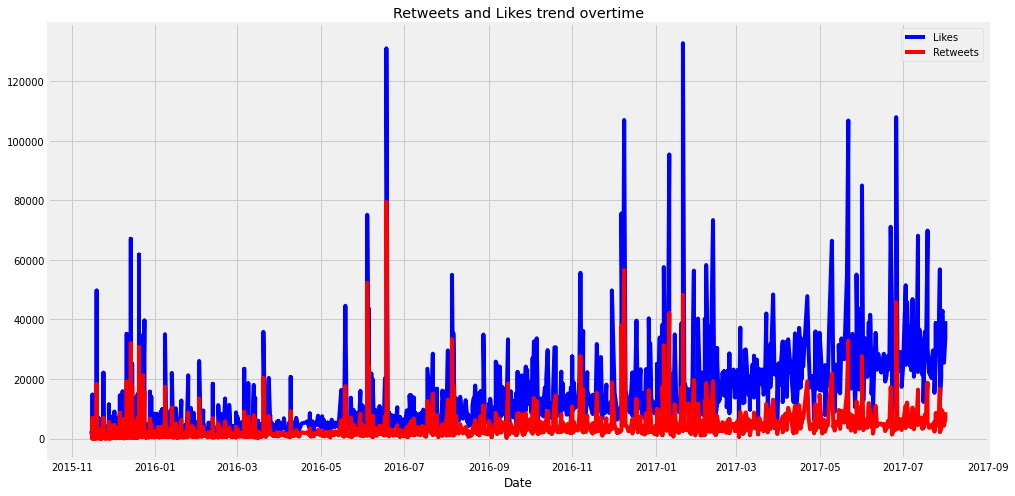

In [92]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(viz_data['date'], viz_data['favorite_count'], color='b', label='Likes')
ax.plot(viz_data['date'], viz_data['retweet_count'], color='r', label='Retweets')
plt.xlabel('Date')
plt.title('Retweets and Likes trend overtime')
plt.legend();

> Observation

- There tends to be relationship between retweets count and likes count because as likes go higher, retweet also go higher.

##### Confirming the correlation between Likes and retweets overtime

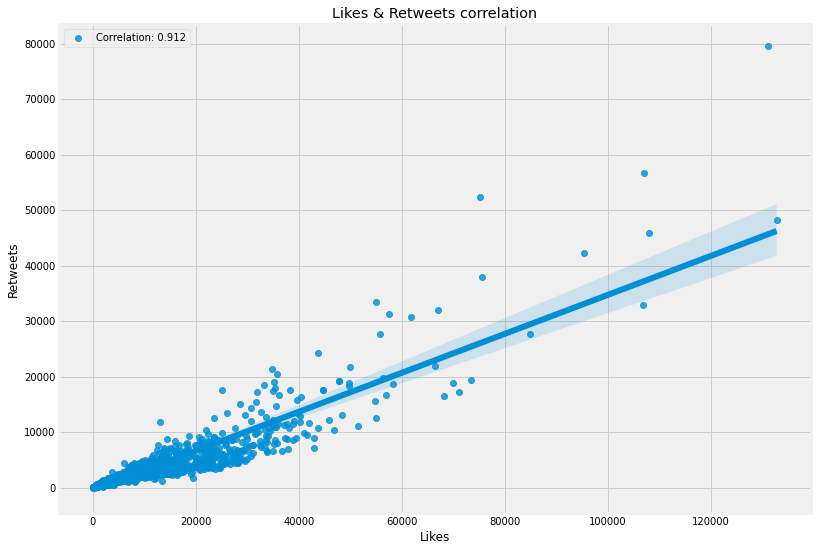

In [93]:
fig, ax = plt.subplots(figsize=(12, 9))
retw_like_cor = round(viz_data.corr().loc['favorite_count', 'retweet_count'], 3) # Correlation
sns.regplot(x=viz_data['favorite_count'], y=viz_data['retweet_count'], ax=ax)
ax.set_xlabel('Likes', fontsize=12)
ax.set_ylabel('Retweets', fontsize=12)
ax.set_title('Likes & Retweets correlation')
ax.legend([(f"Correlation: {retw_like_cor}")]);

> observation

- After showing the relationship between Likes and Retweets count, it can be confidently said that there is 91% correlation between retweet count and tweet likes.

##### Ratings distribution

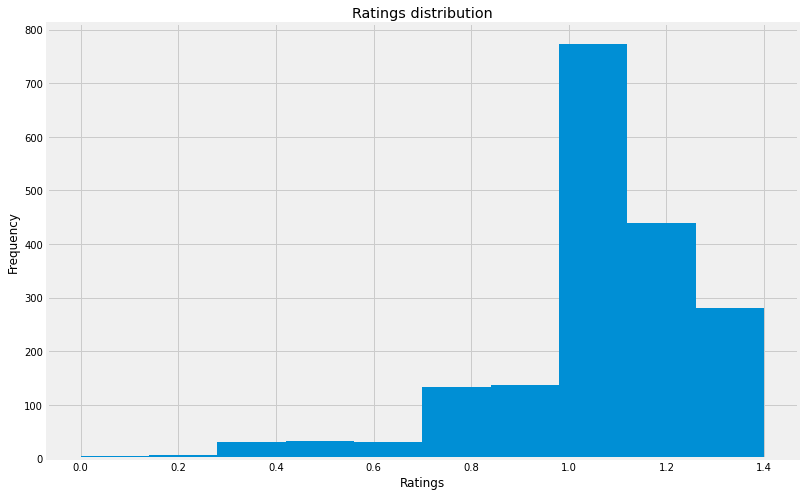

In [94]:
plt.figure(figsize=(12, 8))
viz_data['final_ratings'].plot(kind='hist')
plt.xlabel('Ratings')
plt.title('Ratings distribution');


> Observation

- Ratings distribution is left skewed i.e., Most of the ratings falls between 10-14

##### Dogs with highest ratings

In [95]:
dog_ratings = viz_data[['dog_name', 'final_ratings']].dropna()
dog_ratings.set_index('dog_name', inplace=True)

In [96]:
dog_ratings = dog_ratings['final_ratings'].sort_values(ascending=False)

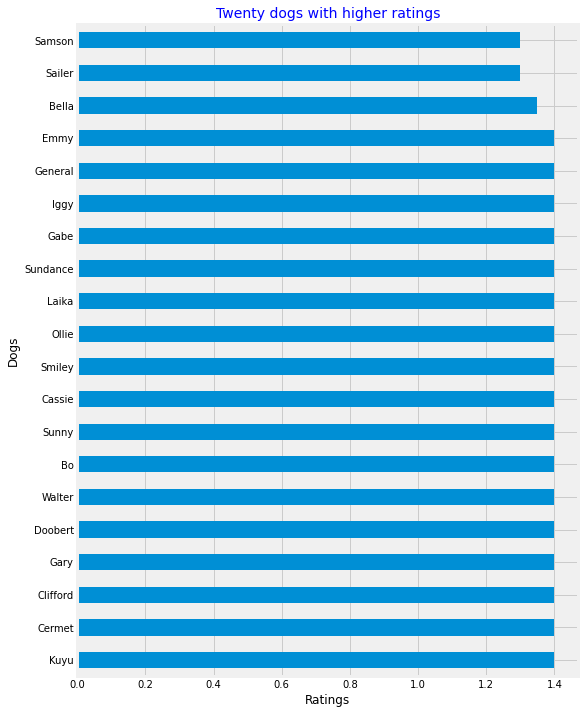

In [97]:
fig, ax = plt.subplots(figsize=(8, 12))
dog_ratings.head(20).plot.barh()
ax.set_ylabel("Dogs")
ax.set_xlabel('Ratings')
ax.set_title("Twenty dogs with higher ratings", size=14, color='b');

> Observation

- Out of all dogs tweet, the above dogs are given higher ratings by WeRateDog

##### Most common dogs breed

In [98]:
# dog breed count with na values
breed_count = (viz_data['dog_breed']
                .value_counts()
                    )

##### Top 10 dog breeds

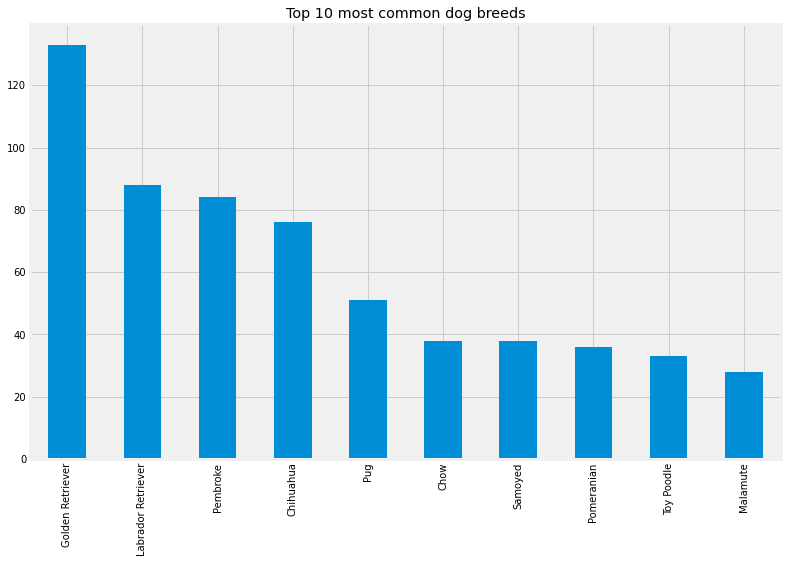

In [99]:
breed_count.head(10).plot.bar(
    figsize=(12, 8), 
    title="Top 10 most common dog breeds"
);

> Observation

- It can be clearly seen that **Golden retriever** dogs breed are the most tweeted dog.

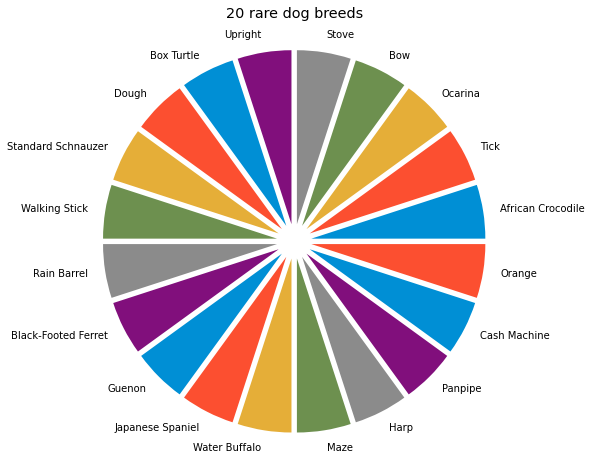

In [100]:
breed_count.tail(20).plot.pie(
    explode=[0.1]*20,
    wedgeprops = {'linewidth': 2},
    figsize=(12, 8), 
    title="20 rare dog breeds",
    ylabel="",
);


> Observation

- The above diagram shows the dog breeds who are rarely tweet.
- The 20 dogs breed have the same interval i.e., posted only once.

#### Top 5 dogs with highest Likes

In [101]:
dog_highest_likes = viz_data.nlargest(5, columns='favorite_count')

dog_highest_likes

,date,retweet_count,favorite_count,dog_name,dog_stage,dog_breed,final_ratings,jpg_url
tweet_id,,,,,,,,
822872901745569793,2017-01-21,48265,132810,NaN,puppo,Lakeland Terrier,1.3,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
744234799360020481,2016-06-18,79515,131075,NaN,doggo,Labrador Retriever,1.3,https://pbs.twimg.com/ext_tw_video_thumb/74423...
879415818425184262,2017-06-26,45849,107956,Duddles,NaN,English Springer,1.3,https://pbs.twimg.com/ext_tw_video_thumb/87941...
807106840509214720,2016-12-09,56625,107015,Stephan,NaN,Chihuahua,1.3,https://pbs.twimg.com/ext_tw_video_thumb/80710...
866450705531457537,2017-05-22,32883,106827,Jamesy,pupper,French Bulldog,1.3,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg


In [102]:
link = dog_highest_likes.loc[:,'jpg_url'][0]

# Dog with highest likes
response = requests.get(link)

##### Dog with highest likes

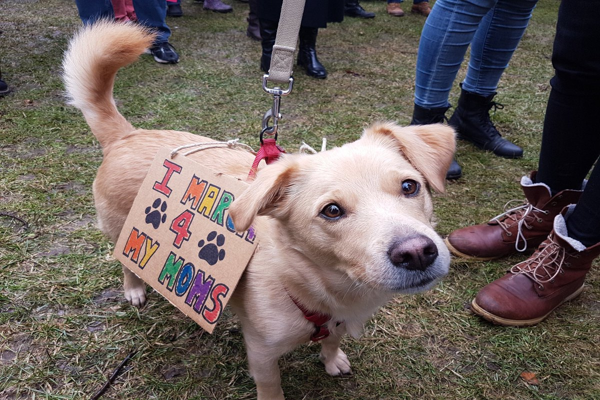

In [103]:
img = Image.open(BytesIO(response.content))
img.resize(size=(600, 400))

#### Top 5 dogs with highest retweets

In [104]:
dog_highest_ret = viz_data.nlargest(5, columns='retweet_count')

dog_highest_ret

,date,retweet_count,favorite_count,dog_name,dog_stage,dog_breed,final_ratings,jpg_url
tweet_id,,,,,,,,
744234799360020481,2016-06-18,79515,131075,NaN,doggo,Labrador Retriever,1.3,https://pbs.twimg.com/ext_tw_video_thumb/74423...
807106840509214720,2016-12-09,56625,107015,Stephan,NaN,Chihuahua,1.3,https://pbs.twimg.com/ext_tw_video_thumb/80710...
739238157791694849,2016-06-04,52360,75163,NaN,doggo,Eskimo Dog,1.3,https://pbs.twimg.com/ext_tw_video_thumb/73923...
822872901745569793,2017-01-21,48265,132810,NaN,puppo,Lakeland Terrier,1.3,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
879415818425184262,2017-06-26,45849,107956,Duddles,NaN,English Springer,1.3,https://pbs.twimg.com/ext_tw_video_thumb/87941...


In [105]:
link = dog_highest_ret.loc[:,'jpg_url'][0]

response = requests.get(link)

##### Dog with highest retweets

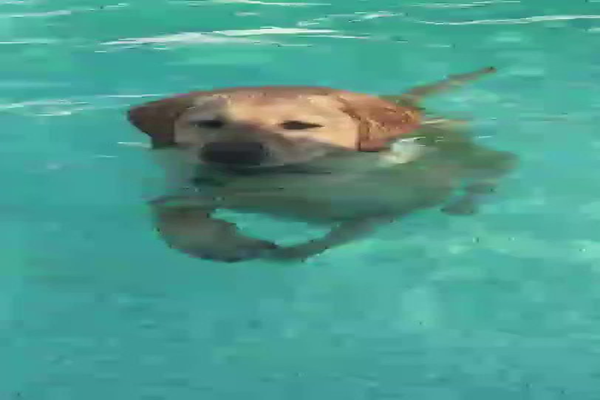

In [106]:
img = Image.open(BytesIO(response.content))
img.resize(size=(600, 400))